<a href="https://colab.research.google.com/github/diliprc96/Dynamic-Programming/blob/main/FrozenLake_using_Dynamic_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group No 160

## Group Member Names:
1. Dilip R 2023ad05030
2. Ishwar Prashanth V 2023ac05162
3. Bharath H M 2023ac05045
4. Hrituj 2023ac05313

1.**Problem statement**:

* Develop a reinforcement learning agent using dynamic programming to solve the Treasure Hunt problem in a FrozenLake environment. The agent must learn the optimal policy for navigating the lake while avoiding holes and maximizing its treasure collection.

2.**Scenario**:
* A treasure hunter is navigating a slippery 5x5 FrozenLake grid. The objective is to navigate through the lake collecting treasures while avoiding holes and ultimately reaching the exit (goal).
Grid positions on a 5x5 map with tiles labeled as S, F, H, G, T. The state includes the current position of the agent and whether treasures have been collected.


#### Objective
* The agent must learn the optimal policy π* using dynamic programming to maximize its cumulative reward while navigating the lake.

#### About the environment

The environment consists of several types of tiles:
* Start (S): The initial position of the agent, safe to step.
* Frozen Tiles (F): Frozen surface, safe to step.
* Hole (H): Falling into a hole ends the game immediately (die, end).
* Goal (G): Exit point; reaching here ends the game successfully (safe, end).
* Treasure Tiles (T): Added to the environment. Stepping on these tiles awards +5 reward but does not end the game.

After stepping on a treasure tile, it becomes a frozen tile (F).
The agent earns rewards as follows:
* Reaching the goal (G): +10 reward.
* Falling into a hole (H): -10 reward.
* Collecting a treasure (T): +5 reward.
* Stepping on a frozen tile (F): 0 reward.

#### States
* Current position of the agent (row, column).
* A boolean flag (or equivalent) for whether each treasure has been collected.

#### Actions
* Four possible moves: up, down, left, right

#### Rewards
* Goal (G): +10.
* Treasure (T): +5 per treasure.
* Hole (H): -10.
* Frozen tiles (F): 0.

#### Environment
Modify the FrozenLake environment in OpenAI Gym to include treasures (T) at certain positions. Inherit the original FrozenLakeEnv and modify the reset and step methods accordingly.
Example grid:




**Expected Outcomes:**
1.	Create the custom environment by modifying the existing “FrozenLakeNotSlippery-v0” in OpenAI Gym and Implement the dynamic programming using value iteration and policy improvement to learn the optimal policy for the Treasure Hunt problem.
2.	Calculate the state-value function (V*) for each state on the map after learning the optimal policy.
3.	Compare the agent’s performance with and without treasures, discussing the trade-offs in reward maximization.
4.	Visualize the agent’s direction on the map using the learned policy.
5.	Calculate expected total reward over multiple episodes to evaluate performance.

### Import required libraries and Define the custom environment - 2 Marks

In [1]:
# Import statements
import numpy as np
import gym
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
import matplotlib.pyplot as plt
import copy

In [2]:
# Custom environment to create the given grid and respective functions that are required for the problem

#Include functions to take an action, get reward, to check if episode is over

class TreasureHuntFrozenLakeEnv(FrozenLakeEnv):
    def __init__(self, desc=None, map_name="5x5", is_slippery=True):
        # Define the 5x5 map with treasures (T)
        desc = np.array([
            "SFFHT",
            "FHFFF",
            "FFFTF",
            "TFHFF",
            "FFFFG"
        ], dtype="c")
        super().__init__(desc=desc, map_name=map_name, is_slippery=is_slippery)
        self.treasure_positions = {(0, 4), (2, 3), (3, 0)}  # Treasure positions in the given map
        self.nS = self.observation_space.n
        self.nA = self.action_space.n
        self.holes = self.desc.flatten() == b'H'
        self.goal = np.where(self.desc.flatten() == b'G')[0][0]

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        # Combine terminated and truncated into a single 'done' flag
        done = terminated or truncated

        row, col = divmod(obs, self.ncol)

        # If the agent steps on a treasure
        if (row, col) in self.treasure_positions:
            reward += 5  # Award +5 for treasure
            self.desc[row, col] = b'F'  # Convert treasure tile to frozen tile
            self.treasure_positions.remove((row, col))
            print(f"Treasure collected at: ({row}, {col}, {reward})")

        # If the agent reaches the goal
        if (row, col) == (4, 4):
            reward += 10  # Goal reward
            # print(f"Goal reached! Reward: {reward}")
        # Convert (row, col) to a 1D index for self.holes
        state_index = row * self.ncol + col

        # Check if the agent is in a hole using the calculated index
        if self.holes[state_index]:
            reward -= 10
            # print(f'hole {reward}')


        # Debug: Log reward after the step
        # print(f"Reward: {reward}, Done: {done}")


        # Return the expected 4 values
        return obs, reward, done, info


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Value Iteration Algorithm - 1 Mark

In [3]:
def compute_q_value(env, value_function, state, action, gamma):
    q_value = 0
    for prob, next_state, reward, done in env.P[state][action]:
        q_value += prob * (reward + gamma * value_function[next_state] * (not done))
    return q_value

def value_iteration(env, gamma=0.99, theta=1e-5):
    value_function = np.zeros(env.nS)  # Initialize value function
    changes = []  # Track convergence

    while True:
        delta = 0
        for state in range(env.nS):
            if state in env.holes or state == env.goal:
                continue  # Skip terminal states
            v = value_function[state]
            value_function[state] = max(compute_q_value(env, value_function, state, action, gamma)
                                        for action in range(env.nA))
            delta = max(delta, abs(v - value_function[state]))
        changes.append(delta)  # Log the maximum change in this iteration

        if delta < theta:  # Stop if value function converges
            break
        # print(f"Delta: {delta}")
        # print(f"Value Function: {value_function}")
        # print(f"changes:  {changes}")
    # Plot convergence
    plt.plot(changes)
    plt.xlabel("Iterations")
    plt.ylabel("Max Change (Delta)")
    plt.title("Value Iteration Convergence")
    plt.show()

    return value_function


### Policy Improvement Function - 1 Mark

In [4]:
def policy_improvement(env, value_function, gamma=0.99):
    policy = np.zeros(env.nS, dtype=int)
    changes = []  # Track convergence of policy improvement

    for state in range(env.nS):
        if state in env.holes or state == env.goal:
            continue
        best_action = np.argmax([compute_q_value(env, value_function, state, action, gamma)
                                 for action in range(env.nA)])
        changes.append(policy[state] != best_action)
        policy[state] = best_action

    # Convergence info
    policy_changes = np.sum(changes)
    print(f"Number of policy changes during improvement: {policy_changes}")

    return policy


### Print the Optimal Value Function

In [5]:
def print_value_function(value_function, env):
    print("Optimal Value Function:")
    grid = np.round(value_function.reshape(env.nrow, env.ncol), 2)
    print(grid)


### Visualization of the learned optimal policy - 1 Mark

In [6]:
def visualize_policy_on_map(policy, env):
    """
    Visualize the learned policy as arrows on the map.
    """
    actions = ['←', '↓', '→', '↑']  # Left, Down, Right, Up
    policy_grid = np.array([actions[action] for action in policy]).reshape(env.nrow, env.ncol)

    # Overlay the policy directions on the environment map
    visualization = env.desc.astype(str)  # Convert bytes to strings
    for row in range(env.nrow):
        for col in range(env.ncol):
            if visualization[row, col] not in ['H', 'G']:  # Exclude holes and goals
                visualization[row, col] = policy_grid[row, col]

    # Display the map with arrows
    print("Policy Visualization on the Map:")
    for row in visualization:
        print(' '.join(row))




### Evaluate the policy - 1 Mark

In [7]:
def evaluate_agent(env, policy, num_episodes=1000):
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    return np.mean(total_rewards)


### Main Execution

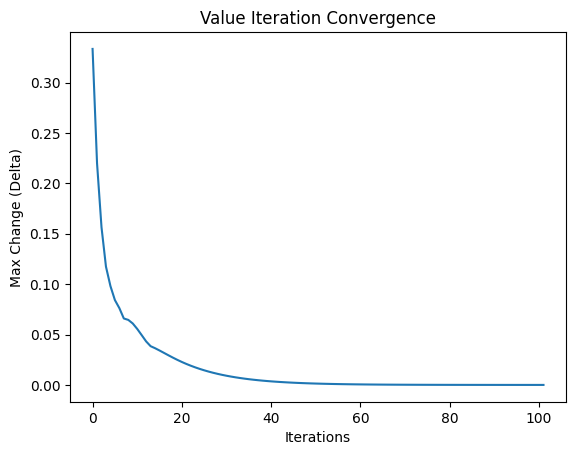

Number of policy changes during improvement: 16
Treasure collected at: (3, 0, 5.0)
Treasure collected at: (2, 3, 5.0)
Treasure collected at: (0, 4, 5.0)
Optimal Value Function:
[[0.   0.   0.27 0.   0.79]
 [0.36 0.   0.55 0.72 0.81]
 [0.73 0.71 0.69 0.81 0.86]
 [0.76 0.75 0.   0.88 0.93]
 [0.79 0.81 0.86 0.93 0.  ]]


In [8]:
env_with_treasures = TreasureHuntFrozenLakeEnv()
value_function_with_treasures = value_iteration(env_with_treasures)
policy_with_treasures = policy_improvement(env_with_treasures, value_function_with_treasures)
average_reward_with_treasures = evaluate_agent(env_with_treasures, policy_with_treasures)
print_value_function(value_function_with_treasures, env_with_treasures)



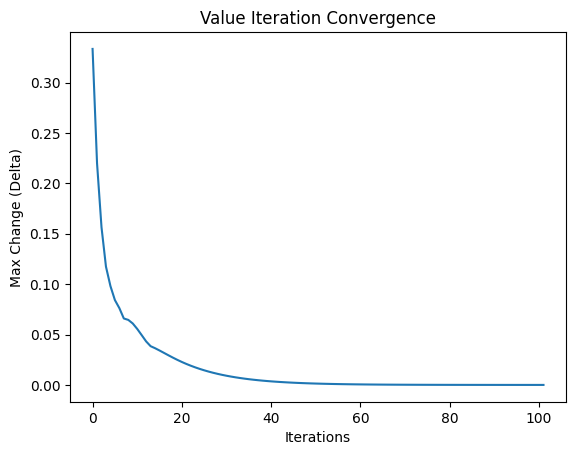

Number of policy changes during improvement: 16
Optimal Value Function:
[[0.   0.   0.27 0.   0.79]
 [0.36 0.   0.55 0.72 0.81]
 [0.73 0.71 0.69 0.81 0.86]
 [0.76 0.75 0.   0.88 0.93]
 [0.79 0.81 0.86 0.93 0.  ]]
Performance Comparison:
Average Reward (With Treasures): 10.469
Average Reward (Without Treasures): 10.034


In [9]:
# Environment without treasures (remove treasure positions)
class FrozenLakeEnvWithoutTreasures(TreasureHuntFrozenLakeEnv):
    def __init__(self):
        super().__init__()
        # Replace all treasure tiles ('T') with frozen tiles ('F')
        self.desc = copy.deepcopy(self.desc)
        self.desc = np.where(self.desc == b'T', b'F', self.desc)
        self.treasure_positions = set()  # Ensure no treasures

env_without_treasures = FrozenLakeEnvWithoutTreasures()
value_function_without_treasures = value_iteration(env_without_treasures)
policy_without_treasures = policy_improvement(env_without_treasures, value_function_without_treasures)
average_reward_without_treasures = evaluate_agent(env_without_treasures, policy_without_treasures)
print_value_function(value_function_without_treasures, env_without_treasures)

# Results
print("Performance Comparison:")
print(f"Average Reward (With Treasures): {average_reward_with_treasures}")
print(f"Average Reward (Without Treasures): {average_reward_without_treasures}")


The average reward with treasures is generally higher than without treasures. However, when using 1000 iterations, the difference in average rewards becomes negligible. This is because the agent converges to an optimal policy relatively early, and the reward differences are diluted over a large number of episodes. Conversely, with 100 iterations, the difference in average rewards is more pronounced (greater than 1). This is attributed to the agent's exploratory behavior in the early episodes, where it actively seeks treasures, resulting in higher rewards before convergence.

In [10]:
env_without_treasures.desc

array([[b'S', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'G']], dtype='|S1')

In [11]:
# Visualize the policy for environments with and without treasures
print("With Treasures:")
visualize_policy_on_map(policy_with_treasures, env_with_treasures)

print("\nWithout Treasures:")
visualize_policy_on_map(policy_without_treasures, env_without_treasures)

With Treasures:
Policy Visualization on the Map:
← ← ← H →
← H → ↓ →
↓ ↓ ↑ → ↓
↓ ← H → ↓
↓ ↓ ↓ → G

Without Treasures:
Policy Visualization on the Map:
← ← ← H →
← H → ↓ →
↓ ↓ ↑ → ↓
↓ ← H → ↓
↓ ↓ ↓ → G
